In [1]:
import random
import math
import itertools
import numpy as np
from sklearn.cluster import spectral_clustering, SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import datetime
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture

import warnings
warnings.filterwarnings('ignore')

n_samples = 600

def accuracy(labels, true_labels):
    total_common = 0
    cluster_names = set(true_labels)
    permutations = list(itertools.permutations(cluster_names))
    for permutation in permutations:
        max_common = 0
        for i, cluster_name in enumerate(cluster_names):
            cluster_nodes = np.where(labels == cluster_name)[0]
            cluster_name1 = permutation[i]
            true_nodes = np.where(true_labels == cluster_name1)[0]

            common = len(set(true_nodes) - (set(true_nodes) - set(cluster_nodes)))
            max_common += common

        total_common = max(total_common, max_common)

    return total_common / len(true_labels)

def get_B_and_weight_vec_ring(points, threshhold=0.2):
    N = len(points)
    clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(points)
    A = clustering.affinity_matrix_

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshhold:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return A, B, weight_vec

     
def algorithm1(B, weight_vec, samplingset, K, alpha, lambda_nLasso):
    E, N = B.shape
    
    seednodesindicator = np.zeros(N)
    seednodesindicator[samplingset] = 1
    noseednodeindicator = np.ones(N)
    noseednodeindicator[samplingset] = 0

    Gamma_vec = np.array(1. / (np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    fac_alpha = 1. / (Gamma_vec * alpha + 1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x / (E - 1) for x in range(0, E)])
    lambda_weight = lambda_nLasso * weight_vec
    gamma_plus = 1 + Gamma_vec[samplingset]
    start = datetime.datetime.now()
    for iterk in range(K):
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        res = abs(newy) / lambda_weight
        res[res < 1] = 1
        haty = newy / res

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

        newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / gamma_plus

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
    
    return newx
    


In [2]:
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.3, noise=.05) 

points = noisy_circles[0] * 2
true_labels = noisy_circles[1]

A, B, weight_vec = get_B_and_weight_vec_ring(points, threshhold=0.2)




In [5]:
M = 0.4
samplingset = random.choices([i for i in range(len(points))], k=int(M * len(points)))

len(samplingset)

240

alpha 0.1 lambda_nLasso 0.5 accuracy 0.9983333333333333
mean_signals [0.00032701 0.00139502 0.00131615 0.00031085 0.00040411 0.00103591
 0.0011296  0.00111774 0.00102707 0.00032191 0.00129231 0.00032787
 0.00040908 0.00030953 0.00125684 0.0012624  0.00031392 0.00096899
 0.00031971 0.00104237]
kmeans.labels_ [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


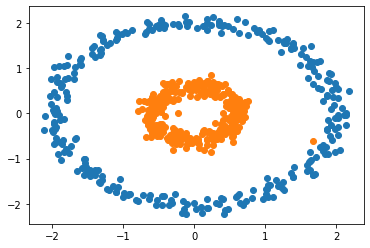

-------------------------------------
alpha 0.1 lambda_nLasso 0.1 accuracy 0.9933333333333333
mean_signals [0.00043601 0.00073361 0.00062725 0.00043358 0.00045408 0.00057855
 0.00061953 0.00061655 0.00060931 0.00043721 0.00070565 0.00043903
 0.00045354 0.00043349 0.00063719 0.00062052 0.00043493 0.00055211
 0.00043562 0.00057797]
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


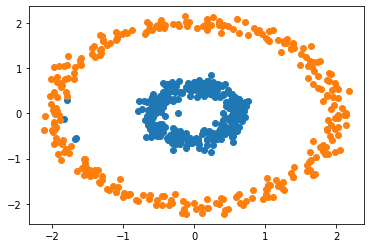

-------------------------------------
alpha 0.1 lambda_nLasso 0.01 accuracy 0.6833333333333333
mean_signals [0.00031327 0.00169442 0.00181468 0.00031303 0.00031524 0.00033115
 0.00033676 0.00161981 0.00175187 0.00031353 0.0003486  0.00031379
 0.00031555 0.00031303 0.00033496 0.00033255 0.00031324 0.00124216
 0.0003133  0.00033103]
kmeans.labels_ [0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


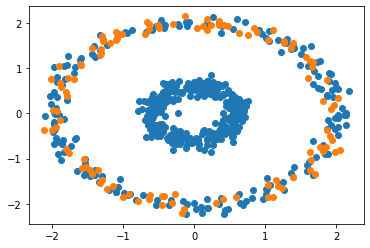

-------------------------------------
alpha 0.1 lambda_nLasso 0.001 accuracy 0.67
mean_signals [4.33203665e-05 2.16343218e-03 2.32518016e-03 4.32919217e-05
 4.35358770e-05 4.53307668e-05 4.59257831e-05 2.11690601e-03
 2.25245030e-03 4.33459025e-05 4.70923552e-05 4.33728365e-05
 4.35775991e-05 5.71289782e-04 4.56890429e-05 4.54204169e-05
 4.33139315e-05 1.70222366e-03 4.33223453e-05 4.53188499e-05]
kmeans.labels_ [0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


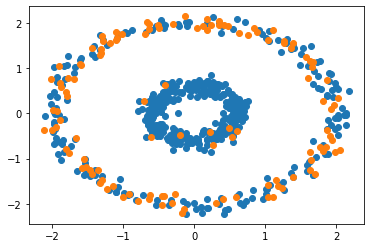

-------------------------------------
alpha 0.01 lambda_nLasso 0.5 accuracy 0.9983333333333333
mean_signals [0.00032613 0.0014247  0.00135432 0.00030933 0.00040607 0.00105904
 0.00115359 0.00114621 0.00105083 0.00032064 0.00131903 0.00032677
 0.00041079 0.00030793 0.00129143 0.00129818 0.00031243 0.00099329
 0.00031844 0.00106595]
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


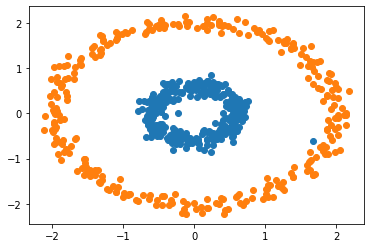

-------------------------------------
alpha 0.01 lambda_nLasso 0.1 accuracy 0.9933333333333333
mean_signals [0.00044048 0.00074715 0.00063949 0.00043794 0.00045926 0.00058767
 0.00062959 0.00062809 0.00062034 0.00044168 0.00071834 0.00044355
 0.00045854 0.00043784 0.00064968 0.00063246 0.00043933 0.00056122
 0.00044004 0.00058711]
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


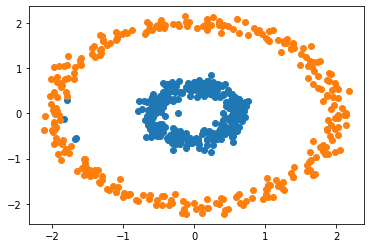

-------------------------------------
alpha 0.01 lambda_nLasso 0.01 accuracy 0.6833333333333333
mean_signals [0.00031721 0.00169968 0.00181952 0.00031695 0.00031927 0.00033579
 0.00034155 0.00162461 0.00175668 0.00031748 0.00035375 0.00031774
 0.00031958 0.00031696 0.00033986 0.00033736 0.00031717 0.00124665
 0.00031724 0.00033567]
kmeans.labels_ [0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


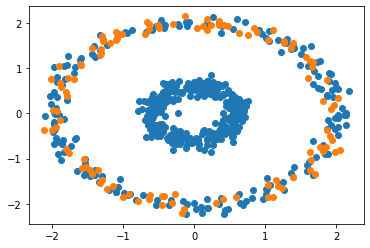

-------------------------------------
alpha 0.01 lambda_nLasso 0.001 accuracy 0.67
mean_signals [4.38626119e-05 2.16412422e-03 2.32582691e-03 4.38326829e-05
 4.40879501e-05 4.59588828e-05 4.65711980e-05 2.11755028e-03
 2.25309712e-03 4.38884776e-05 4.77717700e-05 4.39163752e-05
 4.41301670e-05 5.71826047e-04 4.63429922e-05 4.60639946e-05
 4.38553445e-05 1.70283113e-03 4.38642200e-05 4.59472501e-05]
kmeans.labels_ [0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


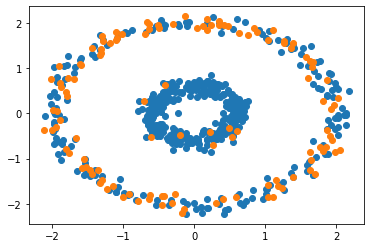

-------------------------------------
alpha 0.001 lambda_nLasso 0.5 accuracy 0.9983333333333333
mean_signals [0.00032603 0.00142771 0.0013582  0.00030917 0.00040627 0.00106139
 0.00115603 0.0011491  0.00105324 0.00032051 0.00132174 0.00032665
 0.00041095 0.00030777 0.00129495 0.00130182 0.00031227 0.00099576
 0.00031831 0.00106835]
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


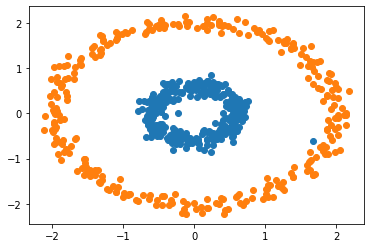

-------------------------------------
alpha 0.001 lambda_nLasso 0.1 accuracy 0.9933333333333333
mean_signals [0.00044093 0.00074852 0.00064074 0.00043838 0.00045978 0.00058859
 0.00063061 0.00062926 0.00062146 0.00044213 0.00071962 0.00044401
 0.00045904 0.00043828 0.00065095 0.00063367 0.00043977 0.00056215
 0.00044049 0.00058804]
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


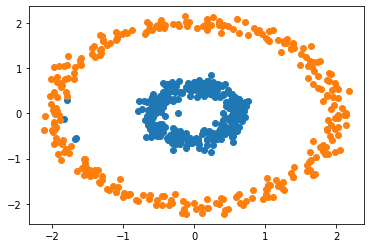

-------------------------------------
alpha 0.001 lambda_nLasso 0.01 accuracy 0.6833333333333333
mean_signals [0.00031761 0.00170021 0.00182    0.00031735 0.00031967 0.00033626
 0.00034203 0.0016251  0.00175716 0.00031788 0.00035427 0.00031814
 0.00031998 0.00031736 0.00034035 0.00033785 0.00031757 0.0012471
 0.00031763 0.00033613]
kmeans.labels_ [0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


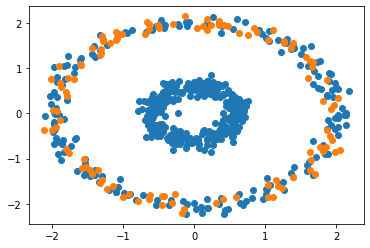

-------------------------------------
alpha 0.001 lambda_nLasso 0.001 accuracy 0.67
mean_signals [4.39173498e-05 2.16419422e-03 2.32589232e-03 4.38872692e-05
 4.41436907e-05 4.60223807e-05 4.66364520e-05 2.11761543e-03
 2.25316253e-03 4.39432485e-05 4.78404762e-05 4.39712442e-05
 4.41859573e-05 5.71880179e-04 4.64091315e-05 4.61290779e-05
 4.39099970e-05 1.70289253e-03 4.39189196e-05 4.60107778e-05]
kmeans.labels_ [0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


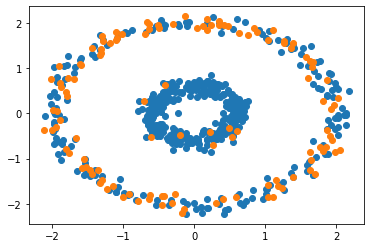

-------------------------------------


In [6]:
K=50
alpha, lambda_nLasso = 0.1, 0.01


for alpha in [0.1, 0.01, 0.001]:
    for lambda_nLasso in [0.5, 0.1, 0.01, 0.001]:
        signals = []
        for node in samplingset:
            res = algorithm1(B, weight_vec, [node], K, alpha, lambda_nLasso)
            signals.append(res)
        signals = np.array(signals)
        mean_signals = np.mean(signals, axis=0)
        X = np.nan_to_num(mean_signals, 0)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
        our_accuracy = accuracy(kmeans.labels_, true_labels)
        print('alpha', alpha, 'lambda_nLasso', lambda_nLasso, 'accuracy', our_accuracy)
        print('mean_signals', mean_signals[:20])
        print('kmeans.labels_', kmeans.labels_[:20])
        print('true_labels', true_labels[:20])
        for label_name in list(set(kmeans.labels_)):
            plt.scatter(points[np.where(kmeans.labels_ == label_name)[0]][:, 0], points[np.where(kmeans.labels_ == label_name)[0]][:, 1], label='0')
    
        plt.show()
        plt.close()
        print('-------------------------------------')




alpha 0.1 lambda_nLasso 0.5 accuracy 0.9983333333333333
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


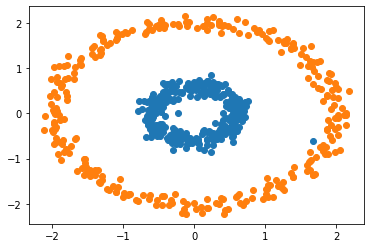

-------------------------------------
alpha 0.1 lambda_nLasso 0.1 accuracy 0.9933333333333333
kmeans.labels_ [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


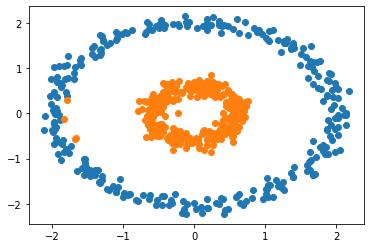

-------------------------------------
alpha 0.1 lambda_nLasso 0.01 accuracy 0.5016666666666667
kmeans.labels_ [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


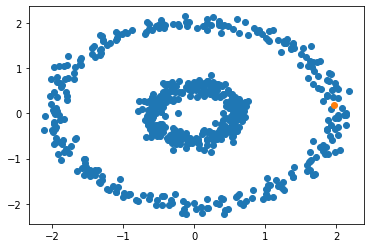

-------------------------------------
alpha 0.1 lambda_nLasso 0.001 accuracy 0.5016666666666667
kmeans.labels_ [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


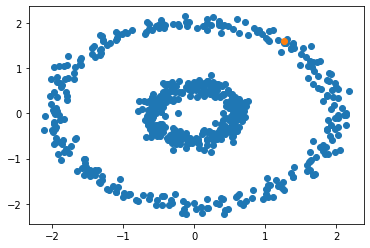

-------------------------------------
alpha 0.01 lambda_nLasso 0.5 accuracy 0.9983333333333333
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


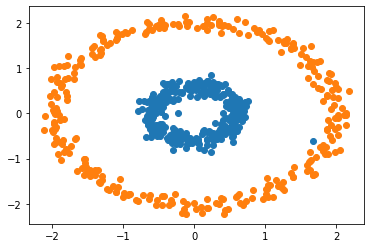

-------------------------------------
alpha 0.01 lambda_nLasso 0.1 accuracy 0.9933333333333333
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


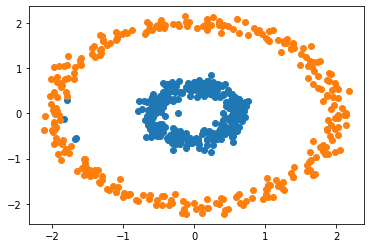

-------------------------------------
alpha 0.01 lambda_nLasso 0.01 accuracy 0.5016666666666667
kmeans.labels_ [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


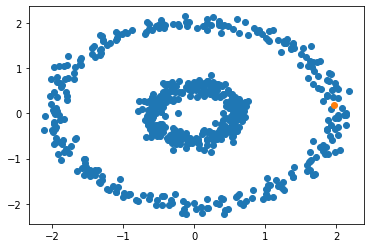

-------------------------------------
alpha 0.01 lambda_nLasso 0.001 accuracy 0.5016666666666667
kmeans.labels_ [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


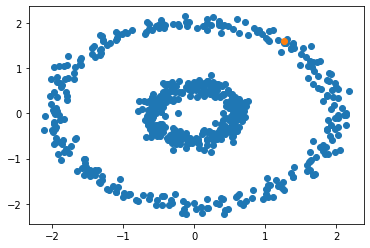

-------------------------------------
alpha 0.001 lambda_nLasso 0.5 accuracy 0.9983333333333333
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


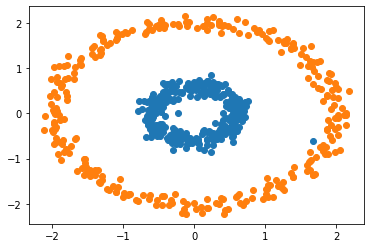

-------------------------------------
alpha 0.001 lambda_nLasso 0.1 accuracy 0.9933333333333333
kmeans.labels_ [0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


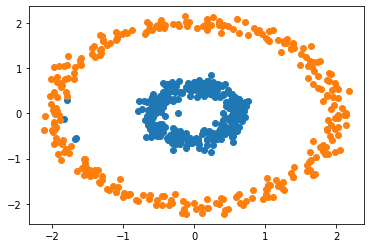

-------------------------------------
alpha 0.001 lambda_nLasso 0.01 accuracy 0.5016666666666667
kmeans.labels_ [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


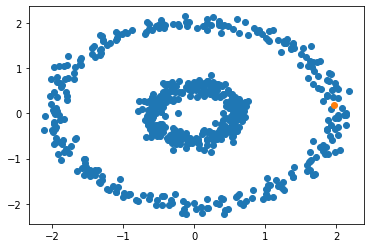

-------------------------------------
alpha 0.001 lambda_nLasso 0.001 accuracy 0.5016666666666667
kmeans.labels_ [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
true_labels [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0]


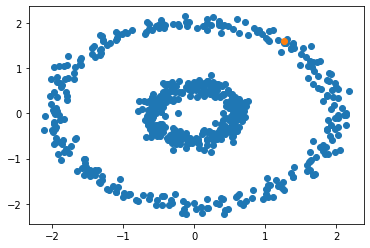

-------------------------------------


In [7]:
for alpha in [0.1, 0.01, 0.001]:
    for lambda_nLasso in [0.5, 0.1, 0.01, 0.001]:
        signals = []
        for node in samplingset:
            res = algorithm1(B, weight_vec, [node], K, alpha, lambda_nLasso)
            signals.append(res)
        signals = np.array(signals)
        signals = signals.T
        X = np.nan_to_num(signals, 0)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
        our_accuracy = accuracy(kmeans.labels_, true_labels)
        print('alpha', alpha, 'lambda_nLasso', lambda_nLasso, 'accuracy', our_accuracy)
        print('kmeans.labels_', kmeans.labels_[:20])
        print('true_labels', true_labels[:20])
        for label_name in list(set(kmeans.labels_)):
            plt.scatter(points[np.where(kmeans.labels_ == label_name)[0]][:, 0], points[np.where(kmeans.labels_ == label_name)[0]][:, 1], label='0')
    
        plt.show()
        plt.close()
        print('-------------------------------------')

